In [1]:
import pandas as pd
from fastai.text import *

In [2]:
pitt_path = Path('../data/Pitt')
model_path = pitt_path.parent/'models'

In [3]:
pitt_df = pd.read_csv(model_path/'pitt.csv')
pitt_df.head()

,Unnamed: 0,group,is_validation,sentence,tagged,text
0,0,control,False,"['the', 'scene', 'is', 'in', 'the', 'kitchen',...","[('the', 'DET:ART', 'the', (1, 2, 'DET')), ('s...",the scene is in the kitchen .
1,1,control,False,"['the', 'mother', 'is', 'wiping', 'dishes', 'a...","[('the', 'DET:ART', 'the', (1, 2, 'DET')), ('m...",the mother is wiping dishes and the water is r...
2,2,control,False,"['a', 'boy', 'is', 'trying', 'to', 'get', 'coo...","[('a', 'DET:ART', 'a', (1, 2, 'DET')), ('boy',...",a boy is trying to get cookies out of a jar an...
3,3,control,False,"['the', 'little', 'girl', 'is', 'reacting', 't...","[('the', 'DET:ART', 'the', (1, 3, 'DET')), ('l...",the little girl is reacting to his falling .
4,4,control,False,"['it', 'seems', 'to', 'be', 'summer', 'out', '.']","[('it', 'PRO:PER', 'it', (1, 2, 'SUBJ')), ('se...",it seems to be summer out .


## fastai API

In [4]:
bs = 128

To create the Language Model, we use all texts and keep 10% for validation.

In [5]:
data_lm = (TextList.from_df(pitt_df, path=model_path, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs)
       )

In [6]:
data_lm.show_batch()

idx,text
0,xxbos the curtains are blowing . xxbos it must be a xxunk breeze . xxbos there 's grass outside in the garden . xxbos kitchen 's very xxunk . xxbos the mother seems to have nothing in the house to eat except cookies in the cookie jar . xxbos the children look to be almost about the same xxunk . xxbos perhaps they 're xxunk . xxbos they 're dressed
1,dishes are on the counter . xxbos window is open . xxbos must be summertime . xxbos the girl is laughing . xxbos looks like she 's laughing . xxbos that 's about it . xxbos . xxbos the boy 's getting cookies out of the cookie jar . xxbos he 's handing one to a girl . xxbos the stool he 's standing on is falling . xxbos the
2,xxbos the mother is stepping in it . xxbos she 's drying her dishes . xxbos the sink is overflowing . xxbos the cups and the saucers are there . xxbos the window is open and you see the lawn outside . xxbos and it must be summertime . xxbos they all have on short sleeves . xxbos and she 's wearing an apron . xxbos okay . xxbos okay
3,xxbos and the sink is running over down on the floor . xxbos the window is up . xxbos and is that all ? xxbos you want something else ? xxbos oh well there 's a plate and two cups on the counter . xxbos xxmaj i_mean is that .. ? xxbos i do n't see anything / . xxbos i see a little boy on a stool trying to
4,doing the dishes at the sink and the sink is overflowing . xxbos the water 's overflowing onto the floor . xxbos she 's drying a dish . xxbos it looks like two cups and a plate on the counter . xxbos outside the window it looks like a path . xxbos and there 's another window and some trees apparently and grass and some shrubs . xxbos and there


In [7]:
torch.cuda.empty_cache()

In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


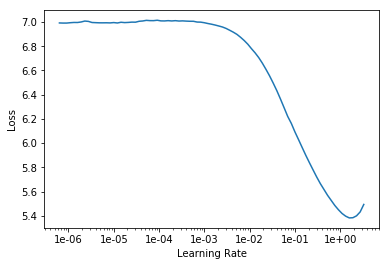

In [10]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 3e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.162636,3.113842,0.417299,00:02


In [13]:
learn.save('fit_head')

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(10, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.952421,2.728990,0.454297,00:02
1,2.786724,2.712640,0.451953,00:02
2,2.674646,2.624758,0.466462,00:02
3,2.558348,2.579371,0.472824,00:02
4,2.421053,2.612416,0.474163,00:02
5,2.268893,2.663246,0.468694,00:02
6,2.146150,2.718886,0.472600,00:02
7,1.984227,2.781601,0.473549,00:02
8,1.841332,2.848566,0.473326,00:02
9,1.713779,2.864590,0.472824,00:02


We might be overfitting.

In [16]:
learn.save('fine_tuned')

In [21]:
learn.save_encoder('fine_tuned_enc')

## Classification

In [23]:
data_clas = (TextList.from_df(pitt_df, path=model_path, cols='text', vocab=data_lm.vocab)
                .split_from_df(col='is_validation')
                .label_from_df(cols='group')
                .databunch(bs=bs)
              )

In [24]:
data_clas.show_batch()

text,target
xxbos it looks like she 's sort of laughing at the boy or putting her finger up to her mouth to be quiet so her mother does n't hear who is in the kitchen drying dishes but the water in the sink is overflowing onto the floor and she 's stepping in the water .,control
xxbos well ‡ whoever he is he probably has somebody else on too and then you 're gon na share it with him and wait i do n't know i guess until it 's over or how i do n't know how the xxunk would be .,dementia
xxbos and the xxunk of the family his granddaughter by the name of xxmaj melanie really enjoyed his company and enjoyed listening to stories that he would tell of his xxunk life in the city .,dementia
xxbos and he 's getting a cookie and he 's xxunk a cookie with the little girl who is shushing her mother with her finger and reaching for the cookie at the same time .,control
xxbos and at the same time there 's a daughter i guess a little girl has her hand up and also one finger to tell i guess her brother to do it xxunk .,dementia


In [25]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('fine_tuned_enc')

In [26]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


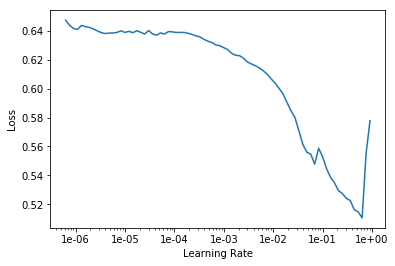

In [27]:
learn_clas.recorder.plot()

In [29]:
lr_clas = 2e-1  #2e-2?

In [30]:
learn_clas.fit_one_cycle(1, lr_clas, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.346113,0.289709,0.864441,00:03


In [31]:
learn_class.save('first')

### Freeze the stem and keep tuning

In [32]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-1/(2.6**4),1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.306032,0.254440,0.882153,00:03


In [33]:
#learn_clas.save('second')

In [35]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(lr_clas*0.1/(2.6**4), lr_clas*0.1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.253910,0.249741,0.887829,00:05


In [36]:
learn_clas.save('third')

### Unfreeze and fit a bit more

In [37]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice((lr_clas/20)/(2.6**4), lr_clas/20), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.231806,0.288489,0.886694,00:06
1,0.221677,0.249897,0.886921,00:06


In [38]:
learn.save('fourth')

## Best model is the third in this run